# Table of Contents

1. Import Libraries
2. Load Dataset
3. Preprocessing and Exploring Text Data
  
  3.1 Text Cleaning
  
  3.2 Finding Word Count

  3.3 Find and Replace Rare Words with "Unknown" Token

4. Data Preparation

  4.1 Prepare Sequences

  4.2 Create Token-Integer Mappings

  4.3 Split Data into Train and Validation Sets

  4.4 Pad Sequences

  4.5 Convert Text Sequences to Integer Sequences
5. Model Building

  5.1 Define Model Architecture
  
  5.2 Start Model Training
6. Text Generation

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
## Pickle library is used to read the pickle type of files
import re
import random
from tqdm import tqdm_notebook

import torch
from torch import nn
import torch.nn.functional as F

In [2]:
# reproducing same results
SEED = 2019

# torch
torch.manual_seed(SEED)

# 2. Load Dataset

In [4]:
# open text file and read in data
with open("dialogs_dataset", "rb") as f:
  dialogs = pickle.load(f)

Note: This is a subset of the Taskmaster dataset available under the Creative Commons Attribution 4.0 License. A full copy of the license can be found at https://creativecommons.org/licenses/by/4.0/. You can access the full dataset from [here](https://github.com/google-research-datasets/Taskmaster/tree/master/TM-1-2019).  

In [5]:
# number of text sequences
len(dialogs)

64776

In [6]:
# print 10 random dialogs
random.sample(dialogs, 10)

["Oh my gosh, you're right",
 "That's exactly right",
 'No that will be all',
 'Elder Theater, Jackson Center Ohio',
 'Awesome, thanks so much',
 'Hey man what’s up?',
 'Probably Michael Jai White',
 'Thank you so much Assistant',
 'How will I recieve my tickets ',
 "I'd like to find a nice restaurant for dinner"]

# 3. Preprocessing and Exploring Text Data

## 3.1 Text Cleaning

In [7]:
# text cleaning
dialogs_clean = []

for i in dialogs:
  # remove everything except alphabets
  i = re.sub("[^a-zA-Z' ]", "", i)
  # convert text to lowercase
  i = i.lower()
  # add cleaned text to the list
  dialogs_clean.append(i)

In [8]:
random.sample(dialogs_clean, 10)

['okay thank you',
 'the largest one they hae',
 'no thank you',
 ' thank you for your help',
 'yeah i like that idea that sounds perfect',
 'hello do you think you can order me two tickets for shazam',
 'ok thank you',
 'yes i would also like to add an order of cinnasquares',
 'hello i need an urgent appointment for my car at intelligent auto solutions',
 'do they offer parking']


## 3.2 Finding Word Count

In [9]:
# get list of all the words
all_words = " ".join(dialogs_clean).split()

words_dict = {}

# add word-count pair to the dictionary
for word in all_words:   
  # check if the word is already in dictionary 
  if word in words_dict:
    # increment count of word by 1 
    words_dict[word] = words_dict[word] + 1
  else:
    # add the word to dictionary with count 1 
    words_dict[word] = 1

In [10]:
# prepare a dataframe
words_df = pd.DataFrame({'word':list(words_dict.keys()), 'count':list(words_dict.values())})

# sort words by their count in increasing order
words_df = words_df.sort_values(by = ['count'])

# reset dataframe index
words_df.reset_index(inplace = True, drop=True)

In [11]:
# vocabulary size
len(words_df)

11147

In [12]:
words_df.head()

,word,count
0,uppermiddle,1
1,shoots,1
2,geesh,1
3,andrea,1
4,precice,1


In [13]:
words_df.tail()

,word,count
11142,you,11909
11143,a,13380
11144,to,14000
11145,the,15406
11146,i,19654


In [17]:
words_df[words_df['count'] < 4]['word']

0       uppermiddle
1            shoots
2             geesh
3            andrea
4           precice
           ...     
7690        corkage
7691         become
7692        pickups
7693          clerk
7694           calm
Name: word, Length: 7695, dtype: object

## 3.3 Find and Replace Rare Words with "Unknown" Token

In [18]:
# user specified threshold value
rare_thresh = 4

# get percentage of rare words in the vocabulary
rare_words_count = len(words_df[words_df['count'] < rare_thresh]['word'])
total_words = len(words_df) 
rare_dist = rare_words_count / total_words

# coverage percentage of rare words in the corpus
rare_cover = words_df[words_df['count'] < rare_thresh]['count'].sum()/words_df['count'].sum()

In [19]:
print(f"Rare words distribution in the vocabulary: {rare_dist*100:.2f}")
print(f"Rare words coverage in the corpus: {rare_cover*100:.2f}")

Rare words distribution in the vocabulary: 69.03
Rare words coverage in the corpus: 2.27


In [20]:
# extract rare words in a list
rare_words = words_df[words_df['count'] < rare_thresh]['word'].tolist()

Let's see the technique that we will use to replace the rare words/tokens in the dataset with a special token known as the unknown token ("\<unk\>")

In [21]:
## example
# specify rare words
r_words = ["day", "book"]

# build pattern
pattern = ""
for i in r_words:
  pattern+= "{}|".format(i)

print(pattern)

day|book|


In [22]:
# removing the last element which is "|"
pattern = pattern[:-1]
print(pattern)

day|book


In [23]:
# replace the rare words with the <unk> token
sents = ["it has been a long day", "this book is a must read"]

for d in sents:
  text = re.sub(pattern, " <unk> ", d)
  print(text)

it has been a long  <unk> 
this  <unk>  is a must read


In [24]:
# create a text pattern from the rare words, like "word1 | word2 | word3..."
pattern = ""
for i in rare_words:
  pattern+= " {} |".format(i)

# removing the last element which is "|"
pattern = pattern[:-1]

# empty list 
dialogs_clean_v2 = []

# replace the rare words with the <unk> token
for d in tqdm_notebook(dialogs_clean):
  text = re.sub(pattern, " <unk> ", d)
  dialogs_clean_v2.append(text)

<ipython-input-24-846b16966f4e>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for d in tqdm_notebook(dialogs_clean):


In [25]:
dialogs_clean_v2[520:530]

['does it serve traditional chinese dessert',
 'how much extra time to reach <unk> ',
 'ok lets reserve a table for dinner at hakkasan',
 'hello i need to get a car please',
 'holiday inn <unk> parkconv <unk> convention center drive <unk> park il',
 'bowling alley <unk> highway <unk> park il',
 'what types of cars does uber have',
 "what's the price difference",
 'ok get me the cheapest please',
 'ok then get me the next level']

# 4. Data Preparation

## 4.1 Prepare Sequences

In [ ]:
# capture length of all the sequences
text_word_count = []
for i in dialogs_clean_v2:
  text_word_count.append(len(i.split()))
        
# plot the sequence lengths
pd.Series(text_word_count).hist(bins = 30,range=(0,30))

In [22]:
# function to create sequences of equal length
def create_seq(text, seq_len = 5):
         
  sequences = []    
  
  if len(text.split()) > seq_len:
    for i in range(seq_len, len(text.split())):
      # select sequence of tokens
      seq = text.split()[i-seq_len:i+1]
      # append sequence to the list
      sequences.append(" ".join(seq))

    return sequences

  else:
    
    return [text]

In [23]:
# create sequences of equal length
seqs = [create_seq(i) for i in dialogs_clean_v2]

In [24]:
seqs[:10]

[["hi i'm looking to book a",
  "i'm looking to book a table",
  'looking to book a table for',
  'to book a table for korean',
  'book a table for korean fod'],
 ['somewhere in southern nyc maybe the',
  'in southern nyc maybe the east',
  'southern nyc maybe the east village'],
 ["we don't want to sit at",
  "don't want to sit at the",
  'want to sit at the bar',
  'to sit at the bar but',
  'sit at the bar but anywhere',
  'at the bar but anywhere else',
  'the bar but anywhere else is',
  'bar but anywhere else is fine'],
 ['what times are available'],
 ["yikes we can't do those times"],
 ['let me check'],
 ["great let's book that"],
 ["no that's it just book"],
 ['hi i would like to see',
  'i would like to see if',
  'would like to see if the',
  'like to see if the movie',
  'to see if the movie what',
  'see if the movie what men',
  'if the movie what men want',
  'the movie what men want is',
  'movie what men want is playing',
  'what men want is playing here'],
 ['yes for m

In [25]:
# merge list-of-lists into a single list
seqs = sum(seqs, [])

In [26]:
seqs[:15]

["hi i'm looking to book a",
 "i'm looking to book a table",
 'looking to book a table for',
 'to book a table for korean',
 'book a table for korean fod',
 'somewhere in southern nyc maybe the',
 'in southern nyc maybe the east',
 'southern nyc maybe the east village',
 "we don't want to sit at",
 "don't want to sit at the",
 'want to sit at the bar',
 'to sit at the bar but',
 'sit at the bar but anywhere',
 'at the bar but anywhere else',
 'the bar but anywhere else is']

In [27]:
# count of sequences
len(seqs)

205346

In [28]:
# create input and target sequences (x and y)
x = []
y = []

for s in seqs:
  x.append(" ".join(s.split()[:-1]))
  y.append(" ".join(s.split()[1:]))

In [29]:
x[0], y[0]

("hi i'm looking to book", "i'm looking to book a")

In [30]:
x[88543], y[88543]

('to drive to several locations', 'drive to several locations do')

## 4.2 Create Token-Integer Mappings

In [31]:
# create integer-to-token mapping
int2token = {}
cnt = 1

for w in set(" ".join(dialogs_clean_v2).split()):
  int2token[cnt] = w
  cnt+= 1

# create token-to-integer mapping
token2int = {t: i for i, t in int2token.items()}

In [32]:
token2int["can"], int2token[1127]

(3170, 'exhausted')

## 4.3 Split Data into Train and Validation Sets

In [33]:
# train-validation split
# input sequences
x_tr = x[:150000]
x_val = x[150000:]

# target sequences
y_tr = y[:150000]
y_val = y[150000:]

## 4.4 Pad Sequences

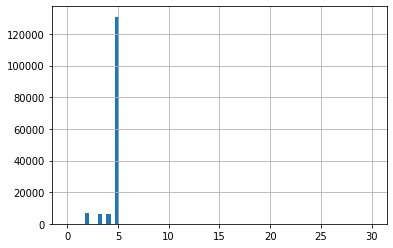

In [34]:
# plot sequence length in train set
text_word_count = []

for i in x_tr:
  text_word_count.append(len(i.split()))

pd.Series(text_word_count).hist(bins = 70,range=(0,30))

In [35]:
# based on the plot above
max_text_len = 5

# function to perform padding
def pad_sequence(seq, n):

  # split input sequence into tokens
  seq = seq.split()
  
  # check if no. of tokens in input sequence is less than 'n'
  if len(seq) < n:
    for i in range(n - len(seq)):
      seq.append("<pad>")

  return " ".join(seq)

# pad text sequences (train set)
x_tr_padded = [pad_sequence(s, max_text_len) for s in x_tr]
y_tr_padded = [pad_sequence(s, max_text_len) for s in y_tr]

# pad text sequences (validation set)
x_val_padded = [pad_sequence(s, max_text_len) for s in x_val]
y_val_padded = [pad_sequence(s, max_text_len) for s in y_val]

In [36]:
x_tr_padded[:20]

["hi i'm looking to book",
 "i'm looking to book a",
 'looking to book a table',
 'to book a table for',
 'book a table for korean',
 'somewhere in southern nyc maybe',
 'in southern nyc maybe the',
 'southern nyc maybe the east',
 "we don't want to sit",
 "don't want to sit at",
 'want to sit at the',
 'to sit at the bar',
 'sit at the bar but',
 'at the bar but anywhere',
 'the bar but anywhere else',
 'bar but anywhere else is',
 'what times are <pad> <pad>',
 "yikes we can't do those",
 'let me <pad> <pad> <pad>',
 "great let's book <pad> <pad>"]

In [37]:
y_tr_padded[:20]

["i'm looking to book a",
 'looking to book a table',
 'to book a table for',
 'book a table for korean',
 'a table for korean fod',
 'in southern nyc maybe the',
 'southern nyc maybe the east',
 'nyc maybe the east village',
 "don't want to sit at",
 'want to sit at the',
 'to sit at the bar',
 'sit at the bar but',
 'at the bar but anywhere',
 'the bar but anywhere else',
 'bar but anywhere else is',
 'but anywhere else is fine',
 'times are available <pad> <pad>',
 "we can't do those times",
 'me check <pad> <pad> <pad>',
 "let's book that <pad> <pad>"]

In [38]:
# update mapping dictionaries
int2token[0] = "<pad>"
token2int["<pad>"] = 0

# set vocabulary size
vocab_size = len(int2token)

## 4.5 Convert Text Sequences to Integer Sequences

In [39]:
# function to create integer sequences
def get_integer_seq(seq):
  return [token2int[w] for w in seq.split()]

In [40]:
# convert text sequences to integer sequences
x_tr_int = [get_integer_seq(i) for i in x_tr_padded]
y_tr_int = [get_integer_seq(i) for i in y_tr_padded]

x_val_int = [get_integer_seq(i) for i in x_val_padded]
y_val_int = [get_integer_seq(i) for i in y_val_padded]

In [41]:
x_tr_int[:10]

[[2478, 5856, 731, 5673, 2249],
 [5856, 731, 5673, 2249, 4709],
 [731, 5673, 2249, 4709, 3575],
 [5673, 2249, 4709, 3575, 4899],
 [2249, 4709, 3575, 4899, 3888],
 [3817, 1075, 928, 5000, 6379],
 [1075, 928, 5000, 6379, 3508],
 [928, 5000, 6379, 3508, 3603],
 [371, 6239, 6027, 5673, 3634],
 [6239, 6027, 5673, 3634, 4954]]

In [42]:
y_tr_int[:10]

[[5856, 731, 5673, 2249, 4709],
 [731, 5673, 2249, 4709, 3575],
 [5673, 2249, 4709, 3575, 4899],
 [2249, 4709, 3575, 4899, 3888],
 [4709, 3575, 4899, 3888, 2413],
 [1075, 928, 5000, 6379, 3508],
 [928, 5000, 6379, 3508, 3603],
 [5000, 6379, 3508, 3603, 2330],
 [6239, 6027, 5673, 3634, 4954],
 [6027, 5673, 3634, 4954, 3508]]

In [43]:
# convert lists into numpy arrays
x_tr_int = np.array(x_tr_int)
y_tr_int = np.array(y_tr_int)

x_val_int = np.array(x_val_int)
y_val_int = np.array(y_val_int)

x_tr_int.shape, y_tr_int.shape, x_val_int.shape, y_val_int.shape

((150000, 5), (150000, 5), (55346, 5), (55346, 5))

# 5. Model Building

## 5.1 Define Model Architecture

In [44]:
# define model architecture
'''Till now we converted the text sequences data into arrays of integer sequences. 
In this part, we will use these arrays to train our LSTM based language model.
So let's define the architecture of the model first. 
1.The model will first take input integer sequences, which will be passed through the embedding layer and the output dimensions
of the output of the embedding layer would be 200 that means, it would generate word embeddings or word vectors of length 200.
and input dimensions for this layer is equal to the vocabulary size, which is equal to the count of distinct tokens in the training set.
'''
## embedding layer: 
##    input dim = vocab_size, 
##    ouput dim = 200
'''Then the output of the embedding layer will be passed to the LSDM layer one time step at a time. 
As you can see over the LSTM architecture(imgine) at time step one, the first token is passed to the model,
at time step two, the second token will be passed to the model and so on. 
And for each time step, the input dimensions are 200, and the output dimensions are 256.
This number of output dimensions can be set by the user. So it can be 256 or it can be set to any other number such as 512 or 120.
It's a hyper parameter. '''
## LSTM layer:
##    input dim = 200
##    hidden units = 256
##    layers = 2
##    output dim = 256
'''Then the output of this LSTM layer will be passed to a dropout layer, so there would be no change in the dimensions. 
'''
## Dropout Layer
##    input dim = 256
##    output dim = 256
'''And finally, the output of the dropout layer will be passed to a fully connected layer. 
So this fully connected layer would be applied at each time step, and the input dimensions would be 256,
and the output dimensions would be a vocabulary size. '''
## fully connected layer
##    input dim = 256
##    ouput dim = vocab_size

'''Now let's see how we can define this architecture in Pytorch.'''
'The model architecute would be define in the class WordLSTM class'
class WordLSTM(nn.Module):
      
  def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.3, lr=0.001):
    super().__init__()
    self.drop_prob = drop_prob
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.lr = lr
    
    self.emb_layer = nn.Embedding(vocab_size, 200)

    ## define the LSTM
    # input data is of shape (batch size, sequence length, no. of features) 3dimentional...
    # ...therefore we need batch_first=True or else by default LSTM layer considers the 1st dimenstion as the sequencd lenth
    self.lstm = nn.LSTM(200, n_hidden, n_layers, batch_first=True)
    
    ## define a dropout layer
    self.dropout = nn.Dropout(drop_prob)
    
    ## define the fully-connected layer
    self.fc = nn.Linear(n_hidden, vocab_size)      
  
  def forward(self, x, hidden):
    ''' Forward pass through the network. 
        These inputs are x, and the hidden/cell state is `hidden`. '''

    ## pass input through embedding layer
    embedded = self.emb_layer(x)     
    
    ## Get the outputs and the new hidden state from the lstm
    ''' Since we are passing batches of  tensors as inputs, output of the embedding layer will be passed to the LSTM layer.
    it will give two outputs: lstm_output, hidden
    "lstm_output" is nothing but a tensors of hidden states from all the time steps.
    "hidden" is the hidden state from the last time step.'''
    
    lstm_output, hidden = self.lstm(embedded, hidden)
    
    ## pass through a dropout layer
    out = self.dropout(lstm_output)
    
    ## reshape the tensor to the shape (batch-size*sequence length, hidden units)
    out = out.reshape(-1, self.n_hidden)

    ## put "out" through the fully-connected layer
    out = self.fc(out)

    # return the final output and the hidden state
    return out, hidden
    
    
  def init_hidden(self, batch_size):
    ''' Initializes hidden state for time step one, here we are creating two tensors.
    One is for the hidden state and the other is for the cell state because an LSTM cell
    has two statess , cellstate and hiddenstate.'''
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data

    if (torch.cuda.is_available()):
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
    else:
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
    
    return hidden

**Q:  weight = next(self.parameters()).data and weight.new() **
- Ans: self.parameters() is a generator method that iterates over the parameters of the model.So weight variable simply holds a parameter of the model.

- Then weight.new() creates a tensor that has the same data type, same device as the produced parameter.

- next retrieve the next item from the iterator by calling its next() method.

In [45]:
# define and print the net
net = WordLSTM()
print(net)

WordLSTM(
  (emb_layer): Embedding(6502, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=6502, bias=True)
)


In [46]:
'''We will be passing batches of tensors as input to the model so we need a function that would create
or generate batches of both input sequence and target sequences.'''
# function to generate batches
def get_batches(arr_x, arr_y, batch_size):
  # iterate through the arrays
  prv = 0
  
  for n in range(batch_size, arr_x.shape[0], batch_size):
    # batch of input sequences
    x = arr_x[prv:n,:]

    # batch of target sequences
    y = arr_y[prv:n,:]

    prv = n
    
    yield x, y

## 5.2 Start Model Training

In [ ]:
'''Till now we define our model, it is time to train it
print_every=32 print the results after every 30 seconds pass to the model.'''

def train(net, epochs=10, batch_size=32, lr=0.001, print_every=32):
      
  # set initial loss to infinite
  best_valid_loss = float('inf')
  
  # optimizer 
  opt = torch.optim.Adam(net.parameters(), lr=lr)
  
  # loss function: In pytorch the way cross entropy loss is defined is that it also
  # applies softmax operation to it's input. Therefore, we did not use the softmax at the final
  # at the final layer in the model architecture
  
  criterion = nn.CrossEntropyLoss()
  
  if(torch.cuda.is_available()):
    # push model to GPU
    net.cuda()
  
  counter = 0

  net.train()

  for e in range(epochs):
            

    # iterate over batches
    for x, y in get_batches(x_tr_int, y_tr_int, batch_size):
      counter+= 1
      
      # convert arrays to tensors
      inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
      
      if(torch.cuda.is_available()):
        # push tensors to GPU
        inputs, targets = inputs.cuda(), targets.cuda()

      # initialize hidden state
      h = net.init_hidden(batch_size)
      '''Note that every time before we pass a battch to model, the hidden state will be
      initialized because otherwise it would carry some information from the previous sequences of the previous batch.
      Ideally, we should initialize hidden state for each sequence in the training data.
      But since we are training the model batch-wise.
      The best that we can do is to initialize the hidden state at the start of each batch.'''

      # set accumulated gradients to zero
      net.zero_grad()
      
      # get the output from the model
      '''output: the output at each time step of all the sequences in the batch.
      h  : final hidden states of all the sequences in the batch.'''
      output, h = net(inputs, h)
      
      # calculate the loss and perform backprop
      loss = criterion(output, targets.view(-1))
      loss.backward()
      
      opt.step()
      
      if counter % print_every == 0:
        '''The default values of print_every is 32, so at every 32nd step, all the validation batches 
        will be passed to the model.'''
        # Get validation loss
        
        val_losses = []

        net.eval()
        for x, y in get_batches(x_val_int, y_val_int, batch_size):
            
          x, y = torch.from_numpy(x), torch.from_numpy(y)
          # torch.from_numpy(x).long()
          
          val_h = net.init_hidden(batch_size)

          inputs, targets = x, y
          if(torch.cuda.is_available()):
            inputs, targets = inputs.cuda(), targets.cuda()

          output, val_h = net(inputs, val_h)

          val_loss = criterion(output, targets.view(-1))
          val_losses.append(val_loss.item())

        #save the best model
        if np.mean(val_losses) < best_valid_loss:
          best_valid_loss = np.mean(val_losses)
          torch.save(net.state_dict(), 'saved_weights.pt')

        net.train()

      
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.4f}...".format(loss.item()),
              "ppl: {:.4f} ".format(np.exp(np.mean(val_losses))),
              "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [48]:
# specify batch size
batch_size = 64

# train the model
train(net, batch_size = batch_size, epochs=10)

Epoch: 1/10... Step: 32... Loss: 6.4697... ppl: 696.1589  Val Loss: 6.5456
Epoch: 1/10... Step: 64... Loss: 5.6610... ppl: 346.2154  Val Loss: 5.8471
Epoch: 1/10... Step: 96... Loss: 6.0162... ppl: 269.5304  Val Loss: 5.5967
Epoch: 1/10... Step: 128... Loss: 5.2267... ppl: 231.3166  Val Loss: 5.4438
Epoch: 1/10... Step: 160... Loss: 6.1923... ppl: 204.2679  Val Loss: 5.3194
Epoch: 1/10... Step: 192... Loss: 5.6782... ppl: 181.0216  Val Loss: 5.1986
Epoch: 1/10... Step: 224... Loss: 5.1817... ppl: 164.4020  Val Loss: 5.1023
Epoch: 1/10... Step: 256... Loss: 4.2399... ppl: 149.1423  Val Loss: 5.0049
Epoch: 1/10... Step: 288... Loss: 4.9247... ppl: 137.4690  Val Loss: 4.9234
Epoch: 1/10... Step: 320... Loss: 4.9262... ppl: 126.9546  Val Loss: 4.8438
Epoch: 1/10... Step: 352... Loss: 4.3369... ppl: 118.3985  Val Loss: 4.7741
Epoch: 1/10... Step: 384... Loss: 5.0263... ppl: 111.4259  Val Loss: 4.7134
Epoch: 1/10... Step: 416... Loss: 4.8335... ppl: 106.5064  Val Loss: 4.6682
Epoch: 1/10... 

# 6. Text Generation

In [76]:
#load weights of best model
path = 'saved_weights.pt'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [77]:
# function to generate one token
def predict(net, tkn, h=None):
         
  # tensor inputs
  x = np.array([[token2int[tkn]]])
  inputs = torch.from_numpy(x)
  
  if(torch.cuda.is_available()):
      inputs = inputs.cuda()

  # get the output of the model
  out, h = net(inputs, h)

  # get the token probabilities
  p = F.softmax(out, dim=1).data

  if(torch.cuda.is_available()):
      p = p.cpu()

  p = p.numpy()
  sampled_token_index = np.argmax(p, axis = 1)[0]
  
  # return the encoded value of the predicted char and the hidden state
  return int2token[sampled_token_index], h

In [78]:
# function to fetch generated sequence
def sample(net, size = 2, seed_text='it is'):
        
    if(torch.cuda.is_available()):
        net.cuda()
    
    net.eval()

    # batch size is 1
    h = net.init_hidden(1)

    toks = seed_text.split()

    # predict next token
    for t in toks:
      token, h = predict(net, t, h)
    
    toks.append(token)

    # predict subsequent tokens
    for i in range(size-1):
        token, h = predict(net, toks[-1], h)
        toks.append(token)

    return ' '.join(toks)

In [79]:
# seed texts
seeds = ["i want to",
         "how about a cup",
         "i don't want",
         "can you send",
         "my car"]

# number of tokens to generate
num_toks = 6

# text generation
for s in seeds:
  # get generated text from the model
  text_gen = sample(net, num_toks, seed_text=s)
  # print the result
  print("seed text:", s, ">> output:",text_gen)
  print("\n")

seed text: i want to >> output: i want to order a pizza from pizza hut


seed text: how about a cup >> output: how about a cup of coffee to pick up from


seed text: i don't want >> output: i don't want to drive it in the morning


seed text: can you send >> output: can you send me the confirmation to the office


seed text: my car >> output: my car is making a weird noise when




## TESTING